# Kaggle: House Price Regression

Project 1 for GWU: Data Analytics Boot Camp  
Michael Ahn, Sam Timura, Salil Deshpande  
This project began as an independent study of machine learning and modeling but was incorporated into an open ended assignment through GWU's Certification course. 

__INTRODUCTION__  
Predictive modeling is a difficult task. While there are myriads of resources available to understand both the heuristic reasoning and mathematical derivations of concepts used in models such as linear regression, it is yet another challenge to put them together in practical use.  

After working on a few toy problems to learn Python, we thought it would be worthwhile to construct this notebook in a format that organizes our thought processes behind each step of this project, which would in turn act as a presentation for those who are also in the beginning steps of becoming a machine learner/ data scientist/ etc.  

__CREDIT__  
During my initial study of python and ML, I came across Kaggle as a goldmine for resources. I immediately started off looking at various kernels, moved towards practicing python, and then came back to complete this project.  
[Data Exploration Tips](https://www.kaggle.com/pmarcelino/comprehensive-data-exploration-with-python)   
[Model Building Tips](https://www.kaggle.com/serigne/stacked-regressions-top-4-on-leaderboard)  
These kernels were invaluable, and our project could not have been completed without their guidance.  

#### TABLE OF CONTENTS
__1. Setting Up Data__  
&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;__- 'SalePrice'__  
&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;__- Outliers__  
&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;__- Missing Values__  
__2. Selecting Numerical Features__  
&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;__- Feature Selection__  
&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;__- Feature Exploration & Engineering__  
__3. Selecting Categorical Features__  
__4. Model Building__  
__5. Model Validation__  
__6. Summary__

# 1. Setting Up Data

A common misconception of predictive modeling is that the process mostly consists of model building. The truth is that a lot, if not most, of the process often consists of steps before really working with models.  

So it is important to prepare its foundations before touching the model. Algorithms are generally judged under 2 criteria, which we can translate slightly for our model: __generalizability__ and __efficiency__. How much predictive power does the model have to new data? Does it take a lot of computations and time to build and use the model?

Although we plan on using various models later on, we started off with the intent of applying Linear Regression which has several assumptions we should check first, and others later on. Two important factors to consider before building a model: __normality__ and __multicollinearity__ of features.

In [1]:
# Hides Warning (Depreciation, etc.)
import warnings
warnings.filterwarnings('ignore')

In [2]:
# Dependencies

# Data Processing and Exploration
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Statistical Exploration Library
import scipy.stats as stats
from minepy import MINE

# Feature Engineering
from sklearn import preprocessing
from sklearn import decomposition
from sklearn import preprocessing

# Modeling
from sklearn import linear_model
from sklearn.ensemble import RandomForestRegressor
from sklearn import model_selection
from sklearn import grid_search
from sklearn.metrics import make_scorer

# Custom Library (Self-Implemented)
import preprocessing as PRE

/Users/mahn/anaconda3/lib/python3.6/site-packages/sklearn/cross_validation.py:41: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)
/Users/mahn/anaconda3/lib/python3.6/site-packages/sklearn/grid_search.py:42: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. This module will be removed in 0.20.
  DeprecationWarning)


In [3]:
# Raw CSV
df_raw = pd.read_csv('train.csv')

### 'SalePrice'

We begin by examining the response feature, 'SalePrice'.  
We want to make sure that there are no odd behaviors in it such as negative prices.

In [4]:
df_raw['SalePrice'].describe() # looks good: we see no $0 houses, or accidental $1

count      1460.000000
mean     180921.195890
std       79442.502883
min       34900.000000
25%      129975.000000
50%      163000.000000
75%      214000.000000
max      755000.000000
Name: SalePrice, dtype: float64

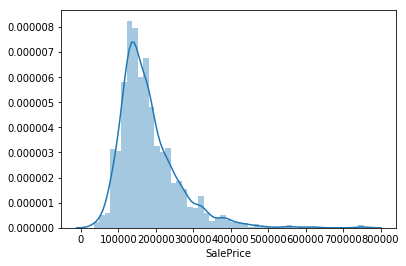

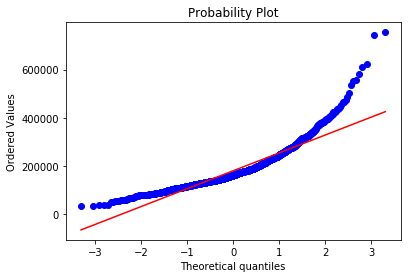

In [5]:
dist = sns.distplot(df_raw['SalePrice'])
plt.figure()
prob = stats.probplot(df_raw['SalePrice'], plot=plt)

A problem however, is in the distribution. It has a clear right skew and shows peakedness, which can be represented numerically with Skewness and Kurtosis statistics. It is pretty clear visually too, and a simple solution involves applying a log transformation.  

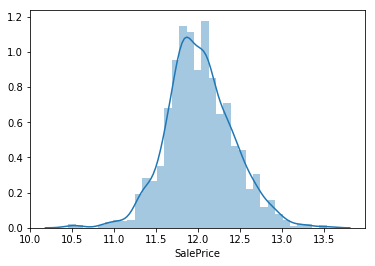

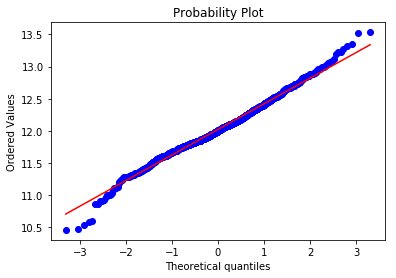

In [6]:
df_full = pd.read_csv('train.csv')
df_full['SalePrice'] = np.log(df_raw['SalePrice'])
dist = sns.distplot(df_full['SalePrice'])
plt.figure()
prob = stats.probplot(df_full['SalePrice'], plot=plt)

A probability plot is a simple way of determining whether data follows a specified distribution. The closer the blue dots follow the red line, the closer the data is to representing that distribution. The stats library defaults to 'normal' for the probplot function, but we can make a probplot for other distributions, too.

### Outliers

Outlier removal follows several specific procedures and is a common topic of study in Statistics. We chose a simple route and removed 2 observations that simply appeared to be outliers. A future goal would be to examine this further.

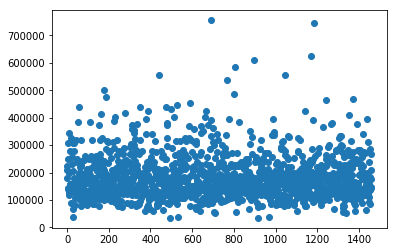

In [7]:
plt.scatter(df_raw['SalePrice'].index, df_raw['SalePrice'])
plt.show()

In [8]:
outliers = np.sort(df_full['SalePrice'])[-2:]
df_full = df_full[df_full['SalePrice'] < np.min(outliers)].reset_index()
df_full.shape

(1458, 82)

### Missing Values

There a few ways to deal with missing values. We can remove the feature containing them, remove the observation, or fill in the observation. The first two choices lead to a loss of information that might be beneficial to our predictive model, while the last option is dangerous because we may create false patterns in the data.

We begin by simply examining the missing values.

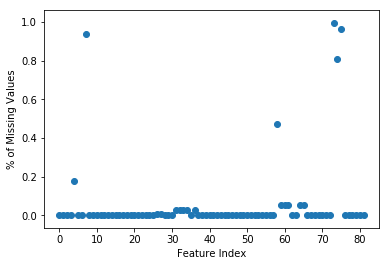

In [9]:
# Calculate percentage of missing observations (rows) per feature
missing = df_full.isnull().sum() / df_full.shape[0]

plt.scatter(range(len(missing)), missing)
plt.ylabel('% of Missing Values')
plt.xlabel('Feature Index')
plt.show()

We can see a fairly clear cutoff where some features are missing a few observations vs a lot of observations. An arbitrary threshold is at 10%, though it seems like it could have been anywhere from about 7-18% based on eye judgment. 

For the rest of the features with missing values, we will try to fill them in with estimations.

In [10]:
# Drop any features missing more than 10% of observations
missing_list = list(missing[missing > 0.1].index)
df_cut = df_full.drop(missing_list, axis=1)

In [11]:
# Isolate features missing < 10% rows
missing2 = df_cut.isnull().sum() / df_full.shape[0]
missing_list2 = missing2[missing > 0].index
df_missing = df_cut[missing_list2]
df_missing.columns

Index(['MasVnrType', 'MasVnrArea', 'BsmtQual', 'BsmtCond', 'BsmtExposure',
       'BsmtFinType1', 'BsmtFinType2', 'Electrical', 'GarageType',
       'GarageYrBlt', 'GarageFinish', 'GarageQual', 'GarageCond'],
      dtype='object')

In [12]:
# Group features
missing_num = ['MasVnrArea', 'GarageYrBlt']

missing_bsmt = ['BsmtCond', 'BsmtExposure', 'BsmtFinType2', 'BsmtFinType1']
missing_garage = ['GarageType', 'GarageQual', 'GarageCond', 'GarageFinish']
missing_mas = ['MasVnrArea', 'MasVnrType']
missing_elec = ['Electrical']

It seems like most of the features with missing values fall into specific categories. Furthermore, looks like a lot of the observations with missing values (per feature type) are missing values for almost __every__ feature. This is a common trait, and might be a significant __pattern__ rather than random chance. An example is in the 'Bsmt_' features.

In [13]:
df_bsmt = df_cut[missing_bsmt]
df_bsmt[df_bsmt.isnull().any(axis=1)].head()

,BsmtCond,BsmtExposure,BsmtFinType2,BsmtFinType1
17,NaN,NaN,NaN,NaN
39,NaN,NaN,NaN,NaN
90,NaN,NaN,NaN,NaN
102,NaN,NaN,NaN,NaN
156,NaN,NaN,NaN,NaN


I put "None" a filler for most of these, following the example of Serigne's kernel. This makes sense since some houses may simply have no Basements, but in the end the actual denotation is irrelevant since "None" simply represents another variable. For the numerical features, I use mean since median ended up being 0 for one of them. 

In [14]:
df_mas = df_cut['MasVnrArea'].fillna(df_cut['MasVnrArea'].mean())
df_gar = df_cut['GarageYrBlt'].fillna(df_cut['GarageYrBlt'].mean())
df_cut = df_cut.fillna('None')

df_cut = df_cut.drop(['MasVnrArea', 'GarageYrBlt'], axis=1)
df_cut = pd.concat([df_mas, df_gar, df_cut], axis=1)
df_cut.isnull().sum().sum() # == 0, no missing values left
df_cut.shape

(1458, 76)

# 2. Selecting Numerical Features

Now that we have prepared our dataframe, we can look at the features themselves. We decided to split this task into two parts: numerical vs categorical features. We specify "numerical" rather than "continuous" because certain features that we decide to treat as numerical can be seen as categorical too, and are not from a continuous scale (e.g. Years). 

We chose 3 ways to __select__ our features:  
1. Correlation  
2. Maximal Information Coefficient  
3. Random Forest  

Then, we take __data exploration__ and __feature engineering__ steps:  
1. Examining Multicollinearity  
2. Dimensionality Reduction (PCA)  
3. Converting Numerical to Categorical  
3. MinMax and BoxCox Transformations

In [15]:
# Extract numerical features by data type
all_num = df_cut.dtypes[df_cut.dtypes != 'object'].index
df_num = df_cut[all_num]

salePrice = df_cut['SalePrice']

### Feature Selection

#### 1. Correlation

Below is an example of a feature with a strong correlation to 'SalePrice'.

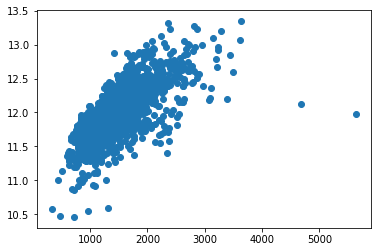

In [16]:
plt.scatter(df_num['GrLivArea'], salePrice)
plt.show()

Correlation coefficients are normalized [-1, 1] scale representations of the mutual tendency of two variables. While there are many formulas to calculate correlation, two popular ones are Pearson Correlation Coefficient and Kendall Rank Correlation.  

Pearson Correlation looks for linear trends. It is calculated using the covariance of two variables. Kendall Tau, on the other hand, ranks the observations and can find nonlinear relationships. We use both.  

In [17]:
# Store Values
lcorr = []
ncorr = []
corr = []
corr_features = []

# Calculate Values
for col in all_num:
    # Pearson Correlation (Linear)
    l, p = stats.pearsonr(salePrice, df_num[col])
    lcorr.append(l)
    
    # Kendall Tau Correlation (Nonlinear)
    n, p = stats.kendalltau(salePrice, df_num[col])
    ncorr.append(n)
    
    # Features and Scores
    corr.append(max(n, l))
    corr_features.append(col)
corr_scores = sorted(zip(corr, corr_features))

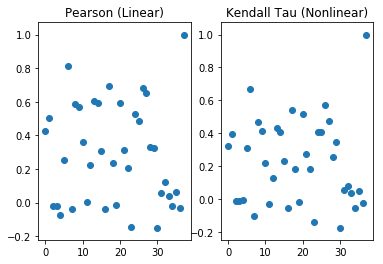

[(-0.14866023652528956, 'EnclosedPorch'),
 (-0.13458356965435384, 'KitchenAbvGr'),
 (-0.037710642699266696, 'LowQualFinSF'),
 (-0.036894197053580269, 'OverallCond'),
 (-0.02078974220211725, 'YrSold'),
 (-0.01976110757063709, 'MiscVal'),
 (-0.013804962547047278, 'BsmtHalfBath'),
 (-0.012842838588763348, 'Id'),
 (-0.012842838588763348, 'index'),
 (-0.0047668652256364786, 'MSSubClass'),
 (0.006386306350464996, 'BsmtFinSF2'),
 (0.037473016006529775, 'PoolArea'),
 (0.056049588009204614, '3SsnPorch'),
 (0.062487215580128277, 'MoSold'),
 (0.12381987321085776, 'ScreenPorch'),
 (0.20412647451874177, 'BedroomAbvGr'),
 (0.22334359414619651, 'BsmtUnfSF'),
 (0.23798223763670498, 'BsmtFullBath'),
 (0.30599441170284486, '2ndFlrSF'),
 (0.31099922097518368, 'HalfBath'),
 (0.31257017386646441, 'LotArea'),
 (0.33046630726957382, 'WoodDeckSF'),
 (0.34984193132322755, 'OpenPorchSF'),
 (0.36272546554816876, 'BsmtFinSF1'),
 (0.42493111084487023, 'MasVnrArea'),
 (0.48459528575929345, 'Fireplaces'),
 (0.502040

In [18]:
# Plot Scores
f = plt.figure()

ax = f.add_subplot(121, title = 'Pearson (Linear)'), 
plt.scatter(range(len(lcorr)), lcorr)

ax = f.add_subplot(122, title = 'Kendall Tau (Nonlinear)'), 
plt.scatter(range(len(ncorr)), ncorr)

plt.show()
corr_scores

Choosing features based off of correlation is subjective. We want to be careful of adding unrelated features with correlation scores due to chance, but also do not want to lose predictive power that a feature might give.  

One way to go about looking at the significance of correlation is to use nonparametric (or parametric, after transforming the data) tests. We again chose to go a simpler route and choose our own cutoff. 

In [19]:
# Arbitrarily choose 0.1 as a cutoff
num_features_corr = []
for i in range(len(corr_scores)):
    if np.abs(corr_scores[i][0]) > 0.1:
        num_features_corr.append(corr_scores[i][1])

#### 2. Maximal Information Coefficients

MICs are very similar to correlation coefficients. They measure the strength of linear __and__ nonlinear relationships between variables on a [0,1] scale.  

An example of using both MIC and correlation is in our first pass at this project. We eliminated all features with missing values, and chose 6 numerical features with a 0.4 correlation cutoff since there was a relatively large gap between the 6th and 7th feature. After running an MIC test, we found that the 7th feature scored only 0.01 less than the 6th, and decided to keep it.  

In this pass, MIC does not play much of a part.

In [20]:
m = MINE() #from minepy
mic_scores = []
mic_labels = []
for col in all_num:
    m.compute_score(df_num[col], salePrice)
    mic_scores.append(m.mic())
    mic_labels.append(str(col))
mic_ = sorted(zip(mic_scores, mic_labels))
mic_

[(0.02399165473984106, 'PoolArea'),
 (0.0739437026380225, '3SsnPorch'),
 (0.0770676012648831, 'LowQualFinSF'),
 (0.08089661586721274, 'MiscVal'),
 (0.0898652580498541, 'MoSold'),
 (0.0952082727855039, 'BsmtFinSF2'),
 (0.09623722013314343, 'BsmtHalfBath'),
 (0.10335126395372093, 'YrSold'),
 (0.10881383116515404, 'ScreenPorch'),
 (0.11144234630274845, 'KitchenAbvGr'),
 (0.1202176300037988, 'Id'),
 (0.1202176300037988, 'index'),
 (0.12081646539242348, 'EnclosedPorch'),
 (0.14204480728865304, 'BsmtFullBath'),
 (0.15416068616961603, 'OverallCond'),
 (0.15470206922143193, 'BedroomAbvGr'),
 (0.16462248052569775, 'BsmtUnfSF'),
 (0.18694538329570778, 'WoodDeckSF'),
 (0.1924158244615384, 'BsmtFinSF1'),
 (0.1972001069158444, 'HalfBath'),
 (0.2094869032713858, 'MasVnrArea'),
 (0.2457343311590598, '2ndFlrSF'),
 (0.25654820361900443, 'LotArea'),
 (0.2654704424726218, 'TotRmsAbvGrd'),
 (0.2779450778635134, 'MSSubClass'),
 (0.28073091160289393, 'OpenPorchSF'),
 (0.2888831087960638, 'YearRemodAdd'),
 (

In [21]:
num_features_mic = []
for i in range(len(mic_)):
    if np.abs(mic_[i][0]) > 0.2:
        num_features_mic.append(mic_[i][1])

#### 3. RandomForest

RandomForest is an algorithm that requires very little preparation to use- a "Plug-and-Chug" method, almost. Since RandomForests automatically deals with multicollinearity, we can throw our numerical features into a RandomForest and see which features the algorithm used the most by looking at the weights.  

A full description of RF is a bit complicated for a textbox, but essentially the weights associated with each feature shows the relative importance of each feature deemed by the algorithm. This method is interesting because we are actually building a crude model.  

We denote df_i vs df_l for "inputs" and "labels". Inputs are the features we use to predict the label. Another word for label would simply be the target variable, 'SalePrice'.

In [22]:
# Preparing Data for RF
train_rf_i, train_rf_l, test_rf_i, test_rf_l = PRE.split_train_test(df_num)

In [23]:
# Build RF 
rf_num = RandomForestRegressor()
rf_num.fit(train_rf_i, train_rf_l)

RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
           max_features='auto', max_leaf_nodes=None,
           min_impurity_decrease=0.0, min_impurity_split=None,
           min_samples_leaf=1, min_samples_split=2,
           min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=1,
           oob_score=False, random_state=None, verbose=0, warm_start=False)

In [24]:
# Evaluate RF
pred = rf_num.predict(test_rf_i)
PRE.score(pred, test_rf_l)

0.14221084045648694

In [25]:
# Important Features
sorted(zip(map(lambda x: round(x, 4), rf_num.feature_importances_), train_rf_i.columns), 
             reverse=True)[:5]

[(0.50700000000000001, 'OverallQual'),
 (0.1298, 'GrLivArea'),
 (0.050900000000000001, 'TotalBsmtSF'),
 (0.043400000000000001, 'GarageCars'),
 (0.039399999999999998, 'BsmtFinSF1')]

If our focus was on building an __efficient__ model, without much computational resources or time on a very large (millions+ rows of data) then these features would be top candidates for building our linear regression model.  

Since our data set is fairly small and our goal leans towards __predictive power__, we include many other features.

In [26]:
num_features_rf = ['OverallQual', 'GrLivArea', 'TotalBsmtSF', 'GarageCars', 'GarageArea']

### Feature Exploration & Engineering

In [27]:
# Gather all important numerical features
num_features = []
num_features_lists = [num_features_rf, num_features_mic, num_features_corr]

for list_ in num_features_lists:
    for feature in list_:
        if feature not in num_features:
            num_features.append(feature)

df_num = df_num[num_features]

#### 1. Multicollinearity

Multicollinearity is a problem for linear regression. When two features are highly correlated, they each bring noise to the model but without much additional information. Not only is this inefficient, but this can lead to our model overfitting the training data. 

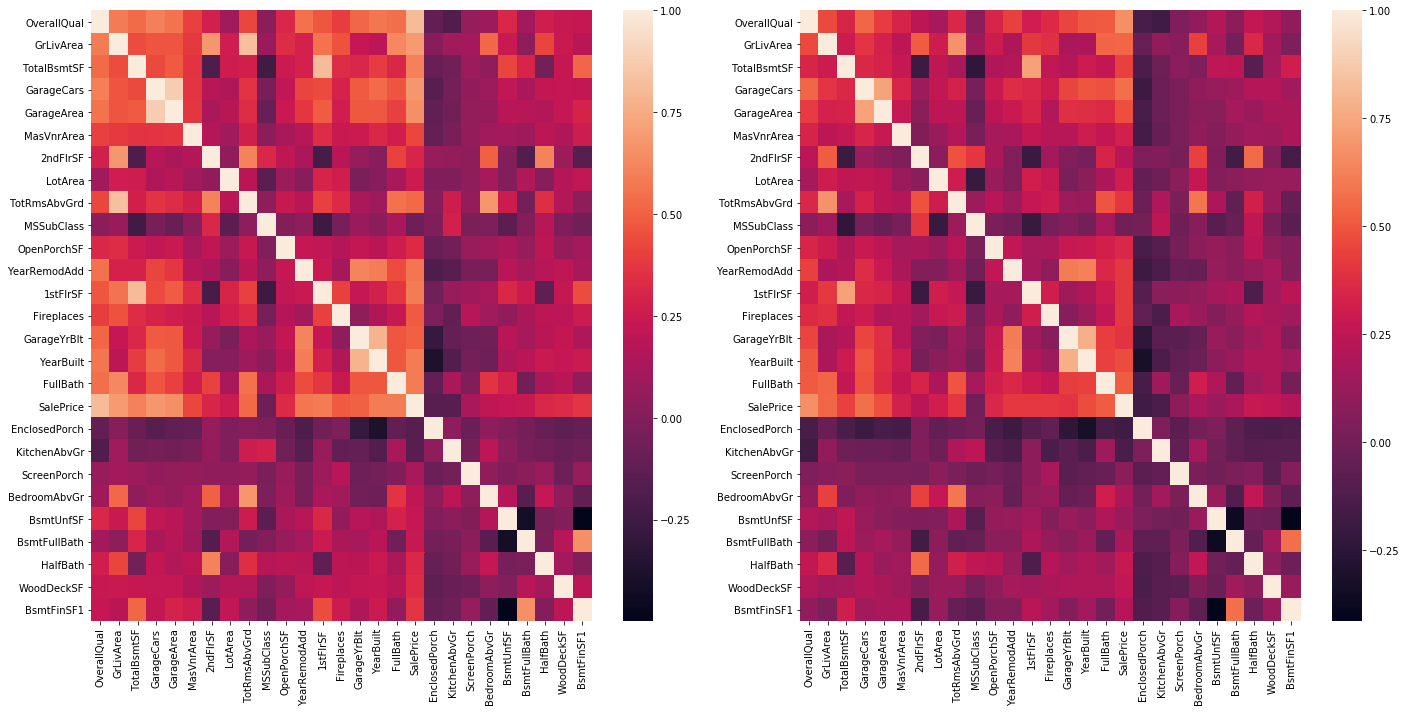

In [28]:
f = plt.figure(figsize=(20, 10))

# Linear
ax = f.add_subplot(121)
sns.heatmap(df_num.corr())

# Nonlinear
ax = f.add_subplot(122)
sns.heatmap(df_num.corr('kendall'))

plt.tight_layout()

It looks like we have 3 pairs of features that are highly correlated. A crossroads for us was in deciding whether to simply treat 'TotRmsAbvGrd' and 'GarageCars' as categorical variables, or continue with our feature engineering as numerical. We chose to keep them as numerical since it seemed easier to deal with.

In [29]:
[stats.pearsonr(df_num['GrLivArea'], df_num['TotRmsAbvGrd']), 
 stats.pearsonr(df_num['1stFlrSF'], df_num['TotalBsmtSF']),
 stats.pearsonr(df_num['GarageArea'], df_num['GarageCars'])]

[(0.82922603971068376, 0.0),
 (0.81699229543212259, 0.0),
 (0.88204005252650441, 0.0)]

#### 2. Dimensionality Reduction (PCA)

Principal Component Analysis deserves a proper introduction.  

PCA is used to reduce the dimensionality of large data sets. Rather than selecting the important featueres however, as the RandomForest method did, it actually creates new ones through linear algebra techniques. Essentially, the algorithm finds the directions of greatest variance in the data. With the setbacks of multicollinearity in mind, PCA produces a linear combination of the old features.  

A useful part of PCA is that it ranks the linear combination of features, the best one being the principal component. While generally used to reduce data sets with thousands+ rows, we use it to combine our highly correlated features. While this may not have a huge impact on the model, it still theoretically improves efficiency.  

A drawback is in the interpretability of the features after applying principal component analysis. It might be difficult to explain to the firm or client how looking at (e.g.) 3.1*'TotalBsmtSF' + 0.91*'1stFlrSF' is better than looking at them individually. 

In [30]:
# Extract 1 component
pca = decomposition.PCA(1)
X1 = pca.fit_transform(df_num[['TotalBsmtSF', '1stFlrSF']])
X1 = pd.DataFrame(X1)
X1.columns = ['TotalBsmtSF_1stFlrSF']

pca = decomposition.PCA(1)
X2 = pca.fit_transform(df_num[['GrLivArea', 'TotRmsAbvGrd']])
X2 = pd.DataFrame(X2)
X2.columns = ['GrLivArea_TotRmsAbvGrd']

pca = decomposition.PCA(1)
X3 = pca.fit_transform(df_num[['GarageArea', 'GarageCars']])
X3 = pd.DataFrame(X3)
X3.columns = ['GarageArea_GarageCars']

In [31]:
df_num = df_num.drop(['TotalBsmtSF', '1stFlrSF','GrLivArea', 'TotRmsAbvGrd','GarageArea', 'GarageCars'], axis=1)
df_num = pd.concat([df_num, X1, X2, X3], axis=1)

#### 3. Converting Numerical to Categorical

While we have been treating each numerical feature as continuous, some are too obviously categorical to continue this facade. Looking at a histogram of their distributions allow for an easy way to see this.

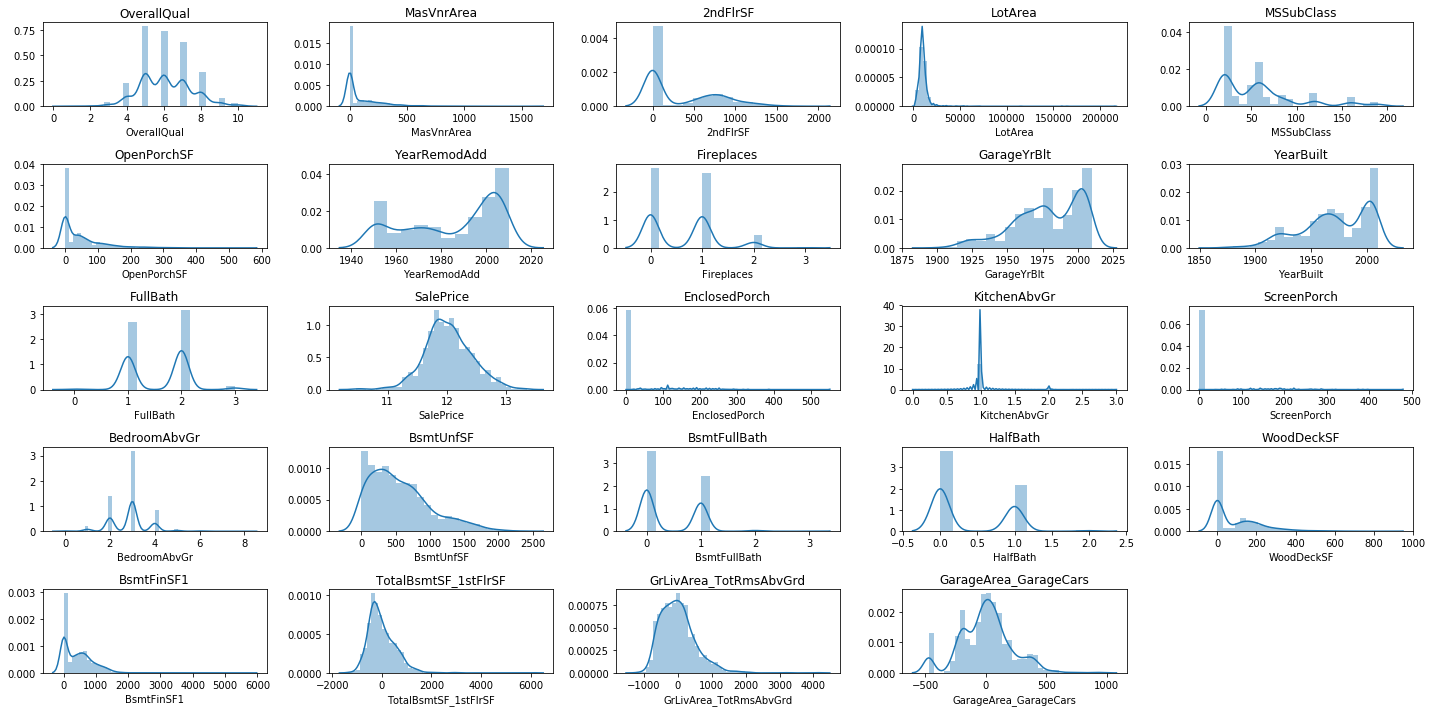

In [32]:
f = plt.figure(figsize=(20,10))
counter = 1
for i in df_num.columns:
    ax = f.add_subplot(5,5,counter)
    sns.distplot(df_num[i])
    plt.title(i)
    
    counter+=1
plt.tight_layout()

Another easy way to determine whether we want to choose which variables should be categorical is to look at the number of unique value_counts(). 

In [33]:
value_count = [(len(df_num[i].value_counts()), i) for i in df_num.columns]
num_to_cat = []
for i in range(len(value_count)):
    if value_count[i][0] < 60:
        num_to_cat.append(value_count[i][1])

In [34]:
df_num_to_cat = df_num[num_to_cat]
df_num = df_num.drop(num_to_cat, axis=1)

#### 4. MinMax and BoxCox Transformations

Lastly, linear regression models perform more efficiently and accurately with scaled data that follow Normal distributions, respectively. 

In [35]:
scaler = preprocessing.MinMaxScaler()
df_num = pd.DataFrame(scaler.fit_transform(df_num), columns=df_num.columns)

from scipy.special import boxcox1p
for i in df_num.drop('SalePrice', axis=1):
    df_num[i] += (df_num[i].describe()['min']+1)
    
    if stats.skew(df_num[i]) < 0:
        df_num[i] = boxcox1p(df_num[i], 2)
    else:
        df_num[i] = boxcox1p(df_num[i], -0.1)   

# 3. Selecting Categorical Features

Selecting categorical features is fairly similar. We can do this graphically, e.g. seeing how 'OverallQual' having a strong relationship with 'SalePrice', or by converting features into numerical and looking again at correlation/ MIC. RandomForest could be another strong indicator, too.  

One interesting method would be building linear regression models and using the R^2 and F Statistic values to see the significance of a single feature in predicting 'SalePrice'. This is more analytic, and would be a better idea when focusing on interpretability.  

Despite these hypothetical paths to choosing variables, we include every single categorical feature in our model.

In [36]:
# Separate categorical features
all_cat = df_cut.dtypes[df_cut.dtypes == 'object'].index
df_cat = df_cut[all_cat]

# Add converted num features
df_cat = pd.concat([df_cat, df_num_to_cat], axis=1)

df_cat['SalePrice'] = salePrice

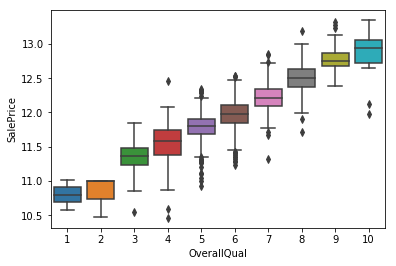

In [37]:
sns.boxplot(x='OverallQual', y='SalePrice', data=df_cat)
plt.show()

Pandas' get_dummies() function splits a categorical feature by every unique value it contains. Each value gets its own columns, becoming a new binary feature (0 or 1). This is a common and easy way to plug categorical values into a sklearn algorithm.

In [38]:
dummies = pd.get_dummies(df_cat.drop('SalePrice',axis=1))

# 4. Model Building

Almost there! Before building our model, there are a few terms and concepts to be understood.  

__Grid Search__ is a convenient function that uses K-Fold validation to find the best parameters for our model functions. It allows us to choose a variety of hyperparameters and tests each combination of them on "k" number of samples from our training set.  

__Ensemble methods__ use a combination of "weak learners" to build a "strong learner". RandomForest is an example of this, as it employs multiple decision trees to make its final prediction. In this kernel, we try out model stacking, an ensemble technique, for the first time.  

__Model Stacking__ uses the same idea of combining learners but instead uses several "not so weak learners" to build a "stronger learner". It involves several __base models__ whos predictions are used on a validation set to create new features for our __meta model__. While most of this notebook involves new concepts, this is the most foreign to us. The steps of our implementation are as follows:  
1. Split data into training, validation, and testing sets  
2. Apply 5-fold grid search on training set to find hyperparameters for base models  
3. Make predictions on training set using base models  
4. Apply 5-fold grid search on predictions to find meta model hyperparameters  
5. Make predictions on validation set using base models  
6. Train meta model on validation set  
7. Compare scores of each base model and meta model on testing set  

A problem might be in applying grid search for the meta model on the same training set that was used to train the base models. By overusing this data, it seems as if we are overfitting the hyperparameters of the base model. Perhaps a better strategy might be to use grid search on the validation set to find hyperparameters for the meta model and simply test it on the testing set.  

We begin with some helper functions to make the process easier.

In [39]:
# Scoring function for grid search
# Grid search ranks parameters "higher" scores as better
def scorer(x, y):
    score = PRE.score(x,y)
    score = 1/score
    return(score)

In [40]:
# Get final score of model on testing set
def final_score(model, i, l):
    score = PRE.score(model.predict(i), l)
    return(score)

In [41]:
# Get best parameters for model using grid search
def get_params(model, params, train_i, train_l):
    clf = grid_search.GridSearchCV(model,
                                  params,
                                  scoring = make_scorer(scorer),
                                  cv=5,
                                  iid=False)
    clf.fit(train_i, train_l)
    params = clf.best_params_
    
    return(params)

#### 1. Split data into training, validation, and testing sets

In [42]:
# Final DataFrame to work with
df = pd.concat([df_num, dummies], axis=1).drop('SalePrice', axis=1)
df = pd.concat([df, df_cut['SalePrice']], axis=1)

# Training Set
train_i, train_l, test1, test2 = PRE.split_train_test(df, frac=0.3)
test = pd.concat([test1, test2], axis=1)

# Validation and Testing Set
cv_i, cv_l, test_i, test_l = PRE.split_train_test(test, frac=0.5)

#### 2. Apply 5-fold grid search on training set to find hyperparameters for base models

In [43]:
# Random Forest
rf_grid = RandomForestRegressor()
params_rf = {'n_estimators':(16, 18, 20, 22, 24), 
          'min_samples_split':(2, 3, 4, 5, 6)}

In [44]:
# Lasso Regression
lasso_grid = linear_model.Lasso()
params_lasso = {'alpha':(0.00001, 0.00005, 0.0001, 0.0005),
         'fit_intercept':(True,False),
         'normalize':(True,False)}

In [45]:
# Ridge Regression
ridge_grid = linear_model.Ridge()
params_ridge = {'alpha':(0.00001, 0.00005, 0.0001, 0.0005),
         'fit_intercept':(True,False),
         'normalize':(True,False)}

In [46]:
# Get best hyperparameters for each model
rf = get_params(rf_grid, params_rf, train_i, train_l)
lasso = get_params(lasso_grid, params_lasso, train_i, train_l)
ridge = get_params(ridge_grid, params_ridge, train_i, train_l)

# Make new models using best hyperparameters
rf_base = RandomForestRegressor(**rf)
lasso_base = linear_model.Lasso(**lasso)
ridge_base = linear_model.Ridge(**ridge)

#### 3. Make predictions on training set using base models

In [47]:
# Fit new base models to training set
rf_base.fit(train_i, train_l)
lasso_base.fit(train_i, train_l)
ridge_base.fit(train_i, train_l)

# Predict on training set
train1 = pd.DataFrame(rf_base.predict(train_i))
train2 = pd.DataFrame(lasso_base.predict(train_i))
train3 = pd.DataFrame(ridge_base.predict(train_i))

# Turn predictions into an "input" df for grid search on meta model
train_stack = pd.concat([train1, train2, train3], axis=1)

#### 4. Apply 5-fold grid search on predictions to find meta model hyperparameters

In [48]:
# Choose ridge regression as meta model
# Grid search meta model using the "input" df from Step 3
stack = linear_model.Ridge()
meta_model = linear_model.Ridge(**get_params(stack, params_ridge, train_i, train_l))

#### 5. Make predictions on validation set using base models

In [49]:
# Predict on validation set
cv1 = pd.DataFrame(rf_base.predict(cv_i))
cv2 = pd.DataFrame(lasso_base.predict(cv_i))
cv3 = pd.DataFrame(ridge_base.predict(cv_i))

# Turn predictions into an "input" dataframe for training meta model
cv_stack = pd.concat([cv1, cv2, cv3], axis=1)

#### 6. Train meta model on validation set

In [50]:
# Train meta model using the "input" df from step 5
meta_model.fit(cv_stack, cv_l)

Ridge(alpha=0.0005, copy_X=True, fit_intercept=False, max_iter=None,
   normalize=True, random_state=None, solver='auto', tol=0.001)

#### 7. Compare scores of each base model and meta model on testing set

In [51]:
# Predict on testing set
test1 = pd.DataFrame(rf_base.predict(test_i))
test2 = pd.DataFrame(lasso_base.predict(test_i))
test3 = pd.DataFrame(ridge_base.predict(test_i))

# Turn predictions into an "input" df for final testing on meta model
test_stack = pd.concat([test1,test2,test3], axis=1)

In [52]:
# RandomForest, Lasso, Ridge final tests
[final_score(model, test_i, test_l) for model in [rf_base, lasso_base, ridge_base]]

[0.14212206468450186, 0.11416512944516931, 0.12485267419361423]

In [53]:
# Meta Model (Ridge) final test
final_score(meta_model, test_stack, test_l)

0.10560138303936276

# 5. Model Validation

#### Accuracy Scores 

It is important to remember that we are predicting log('SalePrice'). If we wanted to translate this into dollars, we would have to apply np.exp() on the predictions and labels before finding the root-mean-square-error.  

Furthermore, our first step of model validation is already completed. We have the scores of each model.  
 
__0.14217 | RandomForest__  
__0.11416 | LassoRegression__   
__0.12485 | RidgeRegression__  

__0.10698 | RidgeRegression (MetaModel)__

Our testing set was untouched during our creation of any of our models. Furthermore, it was randomly sampled from our entire data set. This leads to the assumption that our scores are fair representations of our models' accuracies and generalizabilities to new data of the same domain.  

#### Residuals

It is important to check whether our model's residuals follows any pattern. For example, if we are overpredicting on certain subsets of our data and underpredicting on another, we know to fix our model.  

Our residuals do not appear to be perfectly, randomly, distributed but it does not look too bad either.

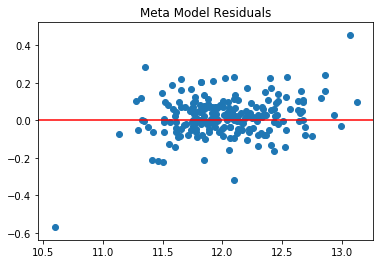

In [54]:
plt.scatter(test_l, test_l - meta_model.predict(test_stack))
plt.title('Meta Model Residuals')
plt.axhline(y=0, color='r', linestyle='-')
plt.show()

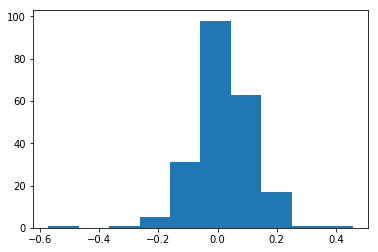

In [60]:
plt.hist(test_l-meta_model.predict(test_stack))
plt.show()

The model assumptions of normal residuals seems good. There does appear to be a slight left skew, but considering we are only predicting on a few hundred observations, this should not be too big of a deal.  

We can go back and actually look at the root-mean-square-error in dollar amounts by applying inverse logs to the predictions and answers themselves before putting them through the scoring function.  

In [59]:
np.power(np.mean(np.square(np.exp(meta_model.predict(test_stack)) - np.exp(test_l))), 0.5)

21543.333793822003

While $21000 seems like a lot of money, the range of data fell originally from ~30-750k. This log score of ~0.1 is fairly close to many of Kaggle's Top 10% submissions.

# 6. Summary

As this was a learning process, there are still many things to improve on.  
- Outlier assumptions   
- Imputing specific missing values  
- Significance checks on correlation coefficients  
- Specifying BoxCox lambda parameters  
- Proper meta model construction (?)  
- Adding more base models (XGBoost, KNN, Naive Bayes, etc)  
- Training different meta model  

Another way to improve model accuracy would be to add more base models, or even try out different metal model algorithms, such as XGBoost.